In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.utils.tensorboard import SummaryWriter
import mlflow
import mlflow.pytorch
import wandb

# pip install tensorboard
# pip install mlflow
# pip install wandb


2024-06-18 11:25:13.175733: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define the RoadDetectionDataset class inheriting from Dataset
class RoadDetectionDataset(Dataset):
    def __init__(self, images_dir, segments_dir, transform=None):
        self.images_dir = images_dir
        self.segments_dir = segments_dir
        self.image_filenames = os.listdir(images_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image = cv2.imread(os.path.join(self.images_dir, img_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        segment = cv2.imread(os.path.join(self.segments_dir, img_name), cv2.IMREAD_GRAYSCALE)
        
        if self.transform:
            augmented = self.transform(image=image, mask=segment)
            image = augmented['image']
            segment = augmented['mask'].unsqueeze(0).float() / 255.0
        
        return image, segment

In [3]:
# Define transformations
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# Directories for datasets
train_images_dir = 'dataset/train/images'
train_segments_dir = 'dataset/train/segments'
val_images_dir = 'dataset/validation/images'
val_segments_dir = 'dataset/validation/segments'
test_images_dir = 'dataset/test/images'
test_segments_dir = 'dataset/test/segments'

# Create dataset instances
train_dataset = RoadDetectionDataset(train_images_dir, train_segments_dir, transform=transform)
val_dataset = RoadDetectionDataset(val_images_dir, val_segments_dir, transform=transform)
test_dataset = RoadDetectionDataset(test_images_dir, test_segments_dir, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)


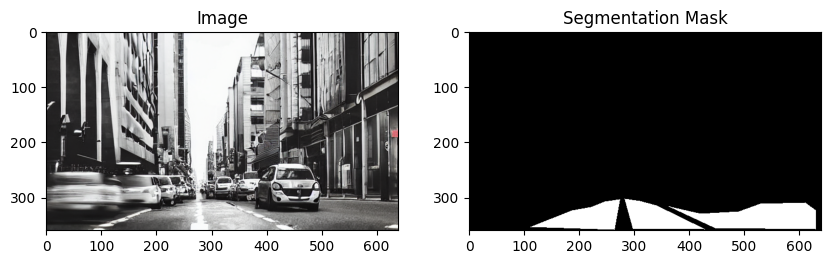

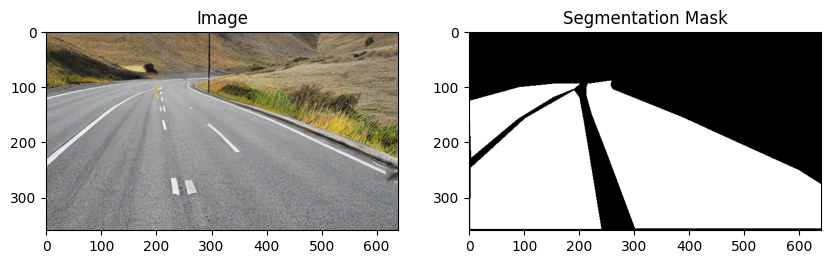

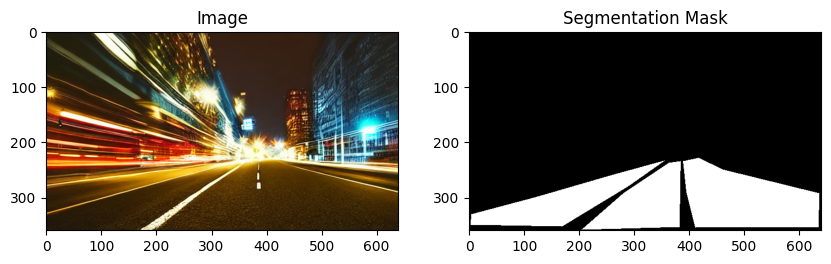

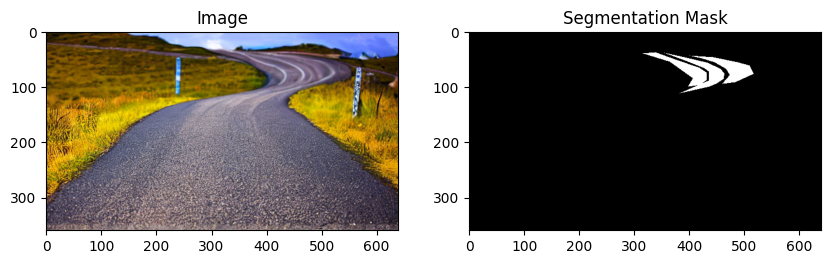

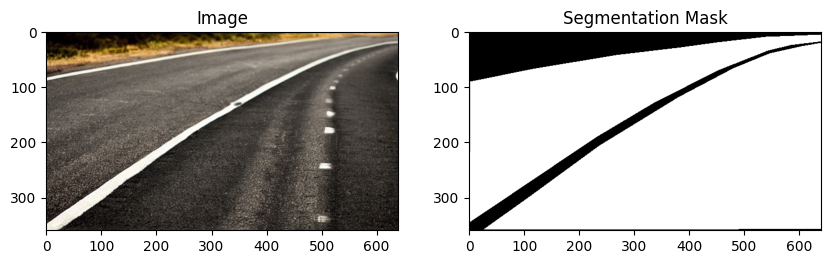

In [4]:
# Visualization function
def visualize_dataset(images_dir, segments_dir, idx):
    img_name = os.listdir(images_dir)[idx]
    image = cv2.imread(os.path.join(images_dir, img_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    segment = cv2.imread(os.path.join(segments_dir, img_name), cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.title("Segmentation Mask")
    plt.imshow(segment, cmap='gray')
    plt.show()

# Visualize a few samples
for i in range(5):
    visualize_dataset(train_images_dir, train_segments_dir, i)


In [5]:
# Evaluate class distribution
def evaluate_class_distribution(segments_dir):
    mask_paths = [os.path.join(segments_dir, fname) for fname in os.listdir(segments_dir)]
    total_pixels = 0
    foreground_pixels = 0
    for path in mask_paths:
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        total_pixels += mask.size
        foreground_pixels += np.sum(mask > 0)
    print(f"Foreground pixels: {foreground_pixels}, Total pixels: {total_pixels}")
    print(f"Foreground pixel percentage: {foreground_pixels / total_pixels * 100:.2f}%")

evaluate_class_distribution(train_segments_dir)

Foreground pixels: 10002810, Total pixels: 36864000
Foreground pixel percentage: 27.13%


In [6]:
# Define the UNet model class
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = self.contracting_block(3, 64)
        self.encoder2 = self.contracting_block(64, 128)
        self.encoder3 = self.contracting_block(128, 256)
        self.encoder4 = self.contracting_block(256, 512)
        self.encoder5 = self.contracting_block(512, 1024)
        self.decoder1 = self.expansive_block(1024, 512)
        self.decoder2 = self.expansive_block(1024, 256)
        self.decoder3 = self.expansive_block(512, 128)
        self.decoder4 = self.expansive_block(256, 64)
        self.final_layer = nn.Conv2d(128, 1, kernel_size=1)

    def contracting_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return block

    def expansive_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return block

    def crop_and_concat(self, upsampled, bypass):
        diffY = bypass.size()[2] - upsampled.size()[2]
        diffX = bypass.size()[3] - upsampled.size()[3]
        upsampled = F.pad(upsampled, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(F.max_pool2d(e1, kernel_size=2, stride=2))
        e3 = self.encoder3(F.max_pool2d(e2, kernel_size=2, stride=2))
        e4 = self.encoder4(F.max_pool2d(e3, kernel_size=2, stride=2))
        e5 = self.encoder5(F.max_pool2d(e4, kernel_size=2, stride=2))
        d1 = self.crop_and_concat(F.interpolate(self.decoder1(F.interpolate(e5, scale_factor=2, mode='bilinear')), scale_factor=2, mode='bilinear'), e4)
        d2 = self.crop_and_concat(F.interpolate(self.decoder2(F.interpolate(d1, scale_factor=2, mode='bilinear')), scale_factor=2, mode='bilinear'), e3)
        d3 = self.crop_and_concat(F.interpolate(self.decoder3(F.interpolate(d2, scale_factor=2, mode='bilinear')), scale_factor=2, mode='bilinear'), e2)
        d4 = self.crop_and_concat(F.interpolate(self.decoder4(F.interpolate(d3, scale_factor=2, mode='bilinear')), scale_factor=2, mode='bilinear'), e1)
        final_output = self.final_layer(d4)
        return final_output

model = UNet()

In [7]:
# Initialize weights
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

model.apply(weights_init)

# Define Dice loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        logits = torch.sigmoid(logits)
        num = targets.size(0)
        logits = logits.view(num, -1)
        targets = targets.view(num, -1)
        intersection = (logits * targets)
        dice = (2. * intersection.sum(1) + self.smooth) / (logits.sum(1) + targets.sum(1) + self.smooth)
        return 1 - dice.mean()

criterion_bce = nn.BCEWithLogitsLoss()
criterion_dice = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Initialize TensorBoard writer
writer = SummaryWriter('runs/road_detection_experiment')

cuda


In [8]:
# Define the training function with TensorBoard logging
def train_with_tensorboard(model, train_loader, val_loader, criterion_bce, criterion_dice, optimizer, scaler, device, num_epochs=10, check_gradients_every_n_epochs=5):
    model.train()
    running_loss = 0.0
    
    for epoch in range(num_epochs):
        for batch_idx, (images, segments) in enumerate(train_loader):
            images, segments = images.to(device), segments.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss_bce = criterion_bce(outputs, segments)
                loss_dice = criterion_dice(outputs, segments)
                loss = loss_bce + loss_dice
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
            
            # Log training loss to TensorBoard
            writer.add_scalar('Training Loss', loss.item(), epoch * len(train_loader) + batch_idx)
        
        if (epoch + 1) % check_gradients_every_n_epochs == 0:
            print(f"Epoch {epoch+1}:")
            for name, param in model.named_parameters():
                if param.grad is not None and 'encoder' in name:
                    print(f"Gradients for {name}: {param.grad.abs().mean().item()}")
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")
        running_loss = 0.0

        val_loss = validate(model, val_loader, criterion_bce, criterion_dice, device)
        writer.add_scalar('Validation Loss', val_loss, epoch)
    
    writer.close()
    return epoch_loss


In [9]:
# Define the validation function
def validate(model, val_loader, criterion_bce, criterion_dice, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, segments in val_loader:
            images, segments = images.to(device), segments.to(device)
            outputs = model(images)
            loss_bce = criterion_bce(outputs, segments)
            loss_dice = criterion_dice(outputs, segments)
            loss = loss_bce + loss_dice
            val_loss += loss.item()
    return val_loss / len(val_loader)

# Train the model with TensorBoard logging
train_with_tensorboard(model, train_loader, val_loader, criterion_bce, criterion_dice, optimizer, scaler, device)


Epoch 1/10, Loss: 1.448606902360916
Epoch 2/10, Loss: 1.1701020181179047
Epoch 3/10, Loss: 1.1262336194515228
Epoch 4/10, Loss: 1.1120751202106476
Epoch 5:
Gradients for encoder1.0.weight: 0.0024251905269920826
Gradients for encoder1.0.bias: 0.006471334025263786
Gradients for encoder1.1.weight: 0.0007729195058345795
Gradients for encoder1.1.bias: 0.0024127664510160685
Gradients for encoder1.3.weight: 0.0005396892665885389
Gradients for encoder1.3.bias: 0.0024263218510895967
Gradients for encoder1.4.weight: 0.0007446291856467724
Gradients for encoder1.4.bias: 0.0015312093310058117
Gradients for encoder2.0.weight: 0.00030930055072531104
Gradients for encoder2.0.bias: 0.0011283070780336857
Gradients for encoder2.1.weight: 0.0002999378484673798
Gradients for encoder2.1.bias: 0.0007370704552158713
Gradients for encoder2.3.weight: 0.00016206300642807037
Gradients for encoder2.3.bias: 0.0006212892476469278
Gradients for encoder2.4.weight: 0.00017704184574540704
Gradients for encoder2.4.bias: 

1.0857243359088897

In [10]:
# Save the trained model
torch.save(model.state_dict(), 'unet_model.pth')
print("Model saved successfully!")

Model saved successfully!


In [11]:
# Denormalize images for visualization
def denormalize_image(image):
    image = image * 0.5 + 0.5
    return image

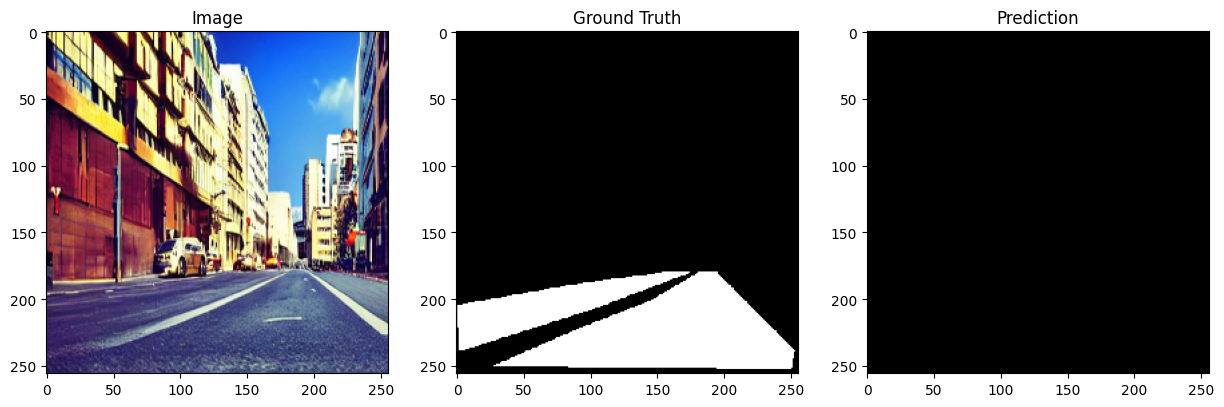

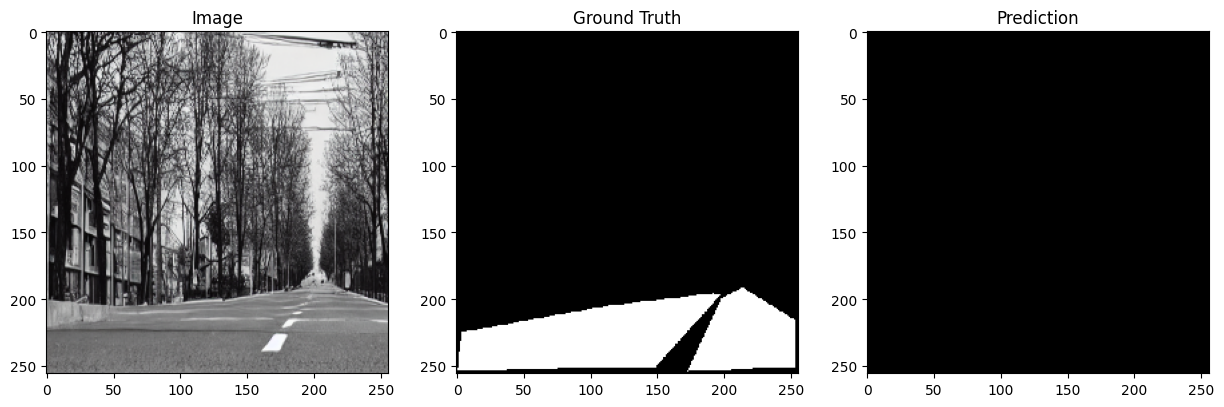

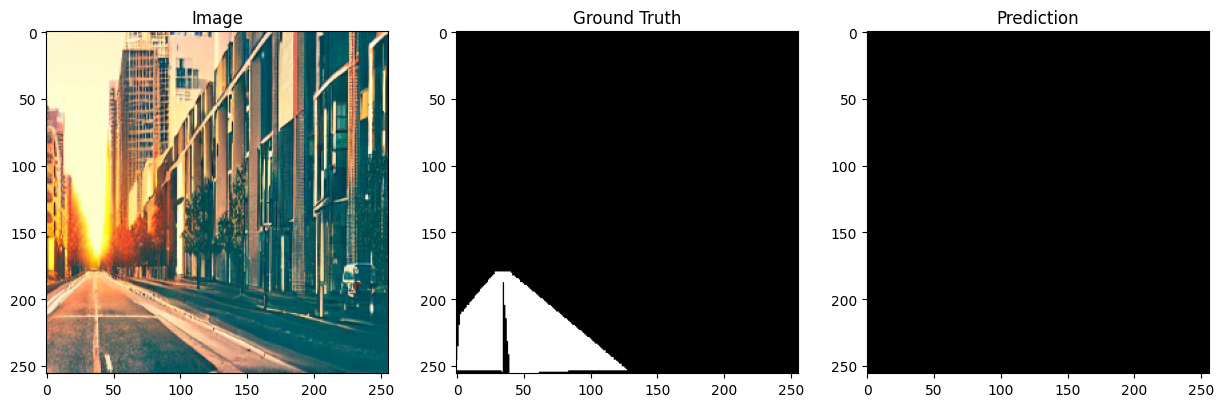

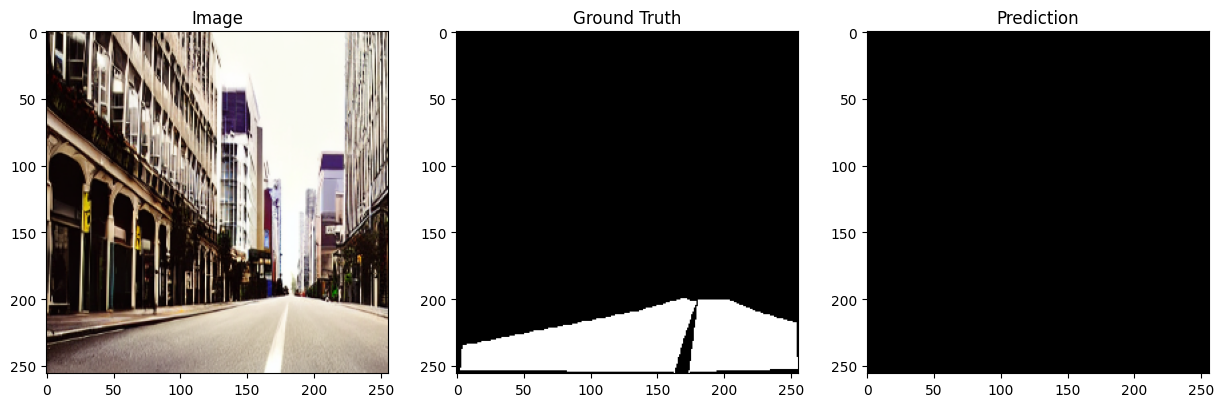

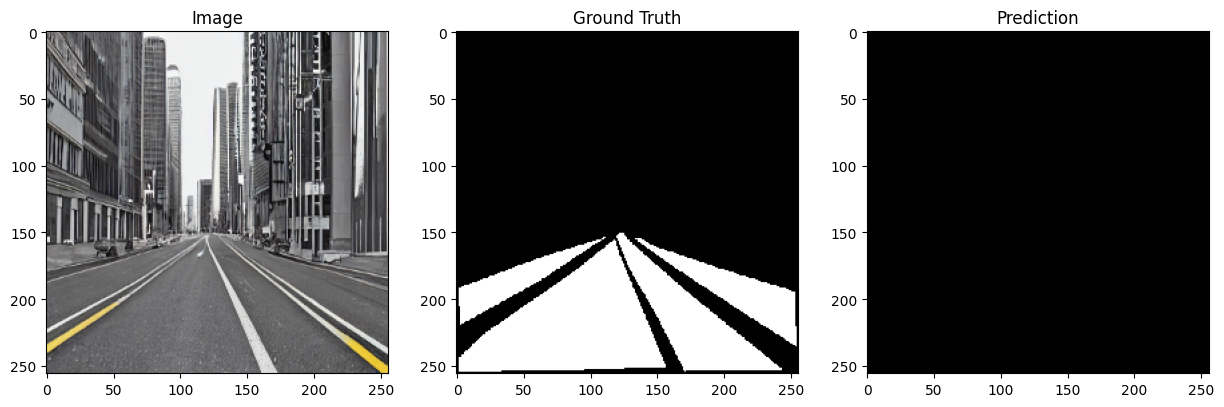

In [12]:
# Visualization of predictions
def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        for i, (images, segments) in enumerate(dataloader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()
            preds = preds > 0.5

            for j in range(images.size(0)):
                if i * images.size(0) + j >= num_images:
                    return
                image = images[j].cpu().numpy().transpose(1, 2, 0)
                segment = segments[j].cpu().numpy().squeeze()
                pred = preds[j].squeeze()

                image = denormalize_image(image)
                image = np.clip(image, 0, 1)

                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.title("Image")
                plt.imshow(image)
                plt.subplot(1, 3, 2)
                plt.title("Ground Truth")
                plt.imshow(segment, cmap='gray')
                plt.subplot(1, 3, 3)
                plt.title("Prediction")
                plt.imshow(pred, cmap='gray')
                plt.show()

# Visualize some predictions
visualize_predictions(model, val_loader, device)

In [ ]:
# How to view tensorboard
# run this command "tensorboard --logdir=runs/road_detection_experiment"

# Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
# TensorBoard 2.x.x at http://localhost:6006/ (Press CTRL+C to quit)


# (unet_env) harsh@harsh:~/Downloads/PROJECTS/road_detection_unet$ tensorboard --logdir=runs/road_detection_experiment
# 2024-06-18 11:28:02.001066: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
# To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
# 2024-06-18 11:28:03.031470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
# 2024-06-18 11:28:03.118141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
# 2024-06-18 11:28:03.121471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355

# NOTE: Using experimental fast data loading logic. To disable, pass
#     "--load_fast=false" and report issues on GitHub. More details:
#     https://github.com/tensorflow/tensorboard/issues/4784

# Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
# TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
# http://localhost:6006/#timeseries